In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/Deep_Db/train.zip','r') as zip:
  zip.extractall('/content')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from tensorflow.keras import layers
import io
from PIL import Image
from IPython.display import display,clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.datasets import load_files
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt



In [ ]:
!pip install -U -q tensorflow-addons

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

In [ ]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 20
image_size = 224
num_classes = 4
input_shape = (224,224, 3)

In [ ]:
labels = ['astro','gbm','normal','oligo']
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/train',i)
    c=0
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        c+=1
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        if c==750:
          break


In [ ]:
len(labels)

4

In [ ]:
len(X_train),len(y_train)

(3000, 3000)

In [ ]:
X_train,y_train=shuffle(X_train,y_train, random_state=69)


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.2,random_state=42)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
images_dict = dict()
x_train_dict=dict()
for i, l in enumerate(y_train_new):
  if len(images_dict)==5:
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((image_size, image_size,3))
images_dict = dict(sorted(images_dict.items()))
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
x_train_each_class = np.asarray(x_trian_each_class)

# example image for each class for test set
X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==5:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [ ]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(labels[y[index]])

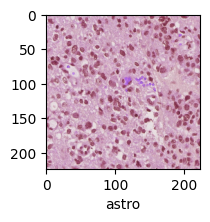

In [ ]:


plot_sample(X_train,y_train_new,0)
plt.show()

In [ ]:

class MCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64,128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="same",
                    use_bias=False,
                    activation='relu',
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(
                layers.SeparableConv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="same",
                    use_bias=False,
                    activation='relu',
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in MCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

def create_mct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    mct_tokenizer = MCTTokenizer()
    encoded_patches = mct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
model = create_Mct_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 cct_tokenizer (CCTTokenize  (None, 3364, 128)            97664     ['data_augmentation[0][0]']   
 r)                                                                                               
                                                                                              

In [ ]:

optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),

        ],
    )

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=4,
        epochs=40,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )


history = pd.DataFrame(history.history)

Epoch 1/40
480/480 [==============================] - 143s 238ms/step - loss: 1.4616 - accuracy: 0.2714 - val_loss: 1.3903 - val_accuracy: 0.2500
Epoch 2/40
480/480 [==============================] - 116s 242ms/step - loss: 1.3348 - accuracy: 0.3365 - val_loss: 1.2231 - val_accuracy: 0.3833
Epoch 3/40
480/480 [==============================] - 118s 247ms/step - loss: 1.1345 - accuracy: 0.4958 - val_loss: 0.9837 - val_accuracy: 0.6521
Epoch 4/40
480/480 [==============================] - 118s 247ms/step - loss: 0.9508 - accuracy: 0.6417 - val_loss: 0.8196 - val_accuracy: 0.7271
Epoch 5/40
480/480 [==============================] - 119s 247ms/step - loss: 0.7886 - accuracy: 0.7734 - val_loss: 0.7439 - val_accuracy: 0.8167
Epoch 6/40
480/480 [==============================] - 118s 245ms/step - loss: 0.7328 - accuracy: 0.8062 - val_loss: 0.7488 - val_accuracy: 0.7688
Epoch 7/40
480/480 [==============================] - 118s 246ms/step - loss: 0.6995 - accuracy: 0.8234 - val_loss: 0.6987 -

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample training and validation accuracy data (replace this with your own data)
epochs = 20
training_accuracy = [0.9014,0.9302,0.9459,0.9530,0.95385,0.95529,0.95689,0.958522,0.9602604,0.961867,0.964226,0.96850,0.9694014,0.9708773,0.9713117,0.9714729,0.9716254,0.9721916,0.972164,0.9723577]
validation_accuracy =[0.918383,0.9423898,0.94941,0.9545131,0.951757,0.9563516,0.9555677,0.9596708,0.9602604,0.9584173,0.967057,0.9673798,0.9676167,0.9689099,0.9703128,0.9703535,0.9707305,0.9707816,0.9705759,0.970774]

# Plotting training and validation accuracy curves
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), training_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(epochs), validation_accuracy, label='Validation Accuracy', marker='>')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
fig = px.line(data_frame=history, y=["loss", "val_loss"], markers=True,)

# Update layout for white background, grid, and figure size
fig.update_layout(
    plot_bgcolor="white",  # Set background color to white
    xaxis=dict(showgrid=True, gridcolor="lightgray"),  # Show x-axis grid
    yaxis=dict(showgrid=True, gridcolor="lightgray"),  # Show y-axis grid
    xaxis_title="Number of Epochs",
    yaxis_title="Loss",
    showlegend=True,
    title={
        "text": "Loss vs Number of Epochs",
        "y": 0.94,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    width=1000,  # Set the width of the figure to 500 pixels
    height=400,  # Set the height of the figure to 1000 pixels
    margin=dict(l=20, r=20, t=20, b=20),  # Add margin around the plot
)

# Show the plot
fig.show()

In [ ]:
fig = px.line(data_frame=history, y=["accuracy", "val_accuracy"], markers=True,)

# Update layout for white background, grid, and figure size
fig.update_layout(
    plot_bgcolor="white",  # Set background color to white
    xaxis=dict(showgrid=True, gridcolor="lightgray"),  # Show x-axis grid
    yaxis=dict(showgrid=True, gridcolor="lightgray"),  # Show y-axis grid
    xaxis_title="Number of Epochs",
    yaxis_title="Accuracy",
    showlegend=True,
    title={
        "text": "Accuracy vs Number of Epochs",
        "y": 0.94,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    width=1000,  # Set the width of the figure to 500 pixels
    height=400,  # Set the height of the figure to 1000 pixels
    margin=dict(l=20, r=20, t=20, b=20),  # Add margin around the plot
)

# Show the plot
fig.show()

19/19 [==============================] - 14s 637ms/step


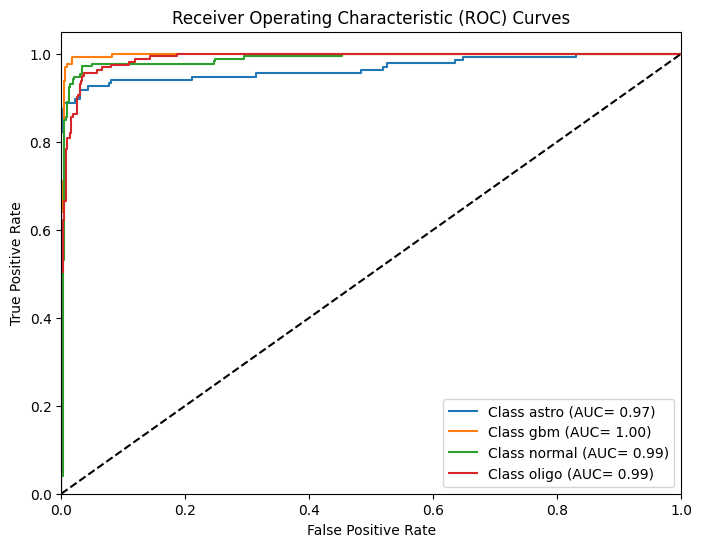

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming 'model' is your Keras functional model
x_train_each_class = ['astro','gbm','normal','oligo']

# Convert multiclass labels to one-hot encoding
y_test_bin = label_binarize(y_test, classes=np.arange(4))

# Get predicted probabilities for each class
y_pred_proba = model.predict(X_test)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {x_train_each_class[i]} (AUC= {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [ ]:
Y_pred=model.predict(X_test)

19/19 [==============================] - 12s 606ms/step


In [ ]:
y_class=[np.argmax(x) for x in Y_pred]
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

1/1 [==============================] - 0s 79ms/step


array([0, 1, 2, 3])

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       135
           1       0.89      1.00      0.94       131
           2       0.98      0.92      0.95       173
           3       0.90      0.96      0.92       161

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

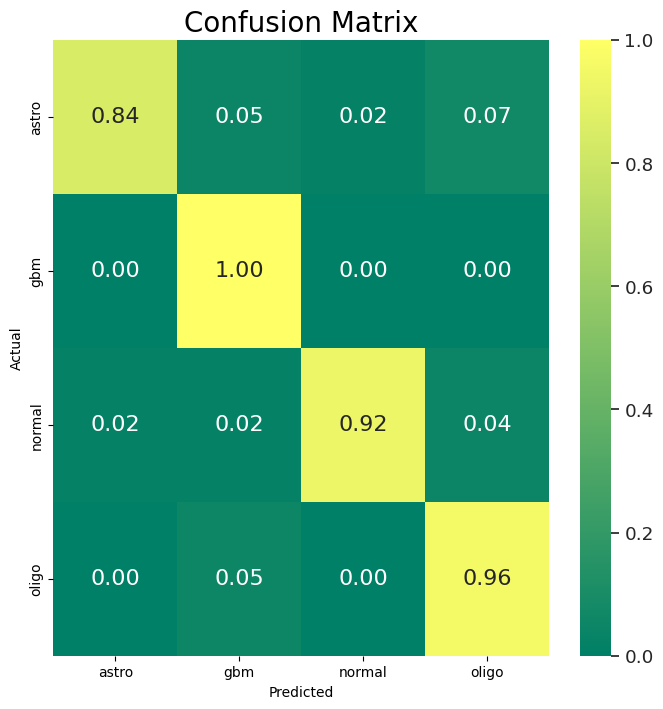

In [ ]:
cm_data = tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm = pd.DataFrame(cm_data, columns=labels, index =labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (8,8))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
cm = cm.astype('float') / cm.sum(axis=1)
sns.heatmap(cm, cbar=True, cmap="summer", annot=True, annot_kws={"size": 16},fmt = '.2f')

TypeError: ignored

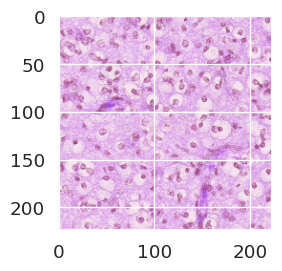

In [ ]:
class_labels = ['astro','gbm','normal','oligo']
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Actual Label:{class_labels[y_test[i]]}\nPredicted Label:{class_labels[predicted_class[i]]}")
    plt.axis("off")